In [155]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from mpl_toolkits.mplot3d import Axes3D

from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, ShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from scipy.spatial.distance import pdist

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

In [156]:
# Ensure 'figures' directory exists
os.makedirs("figures", exist_ok=True)
os.makedirs("models", exist_ok=True)

In [130]:
# Load the datasets
df1 = pd.read_csv('data/simulation_1_1100.csv')
df2 = pd.read_csv('data/simulation_2_699.csv')
df3 = pd.read_csv('data/simulation_3_1580.csv') 
df = pd.concat([df1, df2, df3], ignore_index=True)

df.to_csv('data/simulation_results.csv', index=False)

In [131]:
# General Dataset Metrics
print(f'The dataset size is: {df.shape}')
print('\n')
print(f'the first five entries of the dataset: \n {df.head()}')
total_seconds = df['runtime'].sum()
total_hours = total_seconds / 3600 

print(f"\nTotal simulation time: {total_seconds:.0f} seconds ({total_hours:.2f} hours)")

The dataset size is: (3378, 7)


the first five entries of the dataset: 
          W1        W2         R         t  sigma_max       mass  runtime
0  0.453176  0.109103  0.050891  0.018525  33.511278  38.817408   22.156
1  0.545083  0.173166  0.049431  0.014302  57.556616  41.342222   26.774
2  0.511916  0.132664  0.043735  0.017039  42.156568  45.060976   24.496
3  0.521147  0.145586  0.056524  0.018902  36.736828  51.257317   24.262
4  0.448400  0.147370  0.051096  0.016280  47.511308  31.631060   19.959

Total simulation time: 81754 seconds (22.71 hours)


In [132]:
# Normalize the LHS dataset
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[['W1', 'W2', 'R', 't']])

# Compute LHS pairwise distances
min_dist = np.min(pdist(X_scaled))
mean_dist = np.mean(pdist(X_scaled))
print(f"LHS → Min distance: {min_dist:.4f}")
print(f"LHS → Mean distance: {mean_dist:.4f}")

# Evaluate random sampling over multiple trials
n_trials = 100
min_dists = []
mean_dists = []

for _ in range(n_trials):
    rand_sample = np.random.rand(*X_scaled.shape)
    min_dists.append(np.min(pdist(rand_sample)))
    mean_dists.append(np.mean(pdist(rand_sample)))

avg_min_rand = np.mean(min_dists)
avg_mean_rand = np.mean(mean_dists)

print(f"\nRandom Sampling (avg over {n_trials} trials):")
print(f"→ Avg Min distance: {avg_min_rand:.4f}")
print(f"→ Avg Mean distance: {avg_mean_rand:.4f}")

LHS → Min distance: 0.0161
LHS → Mean distance: 0.7737

Random Sampling (avg over 100 trials):
→ Avg Min distance: 0.0127
→ Avg Mean distance: 0.7773


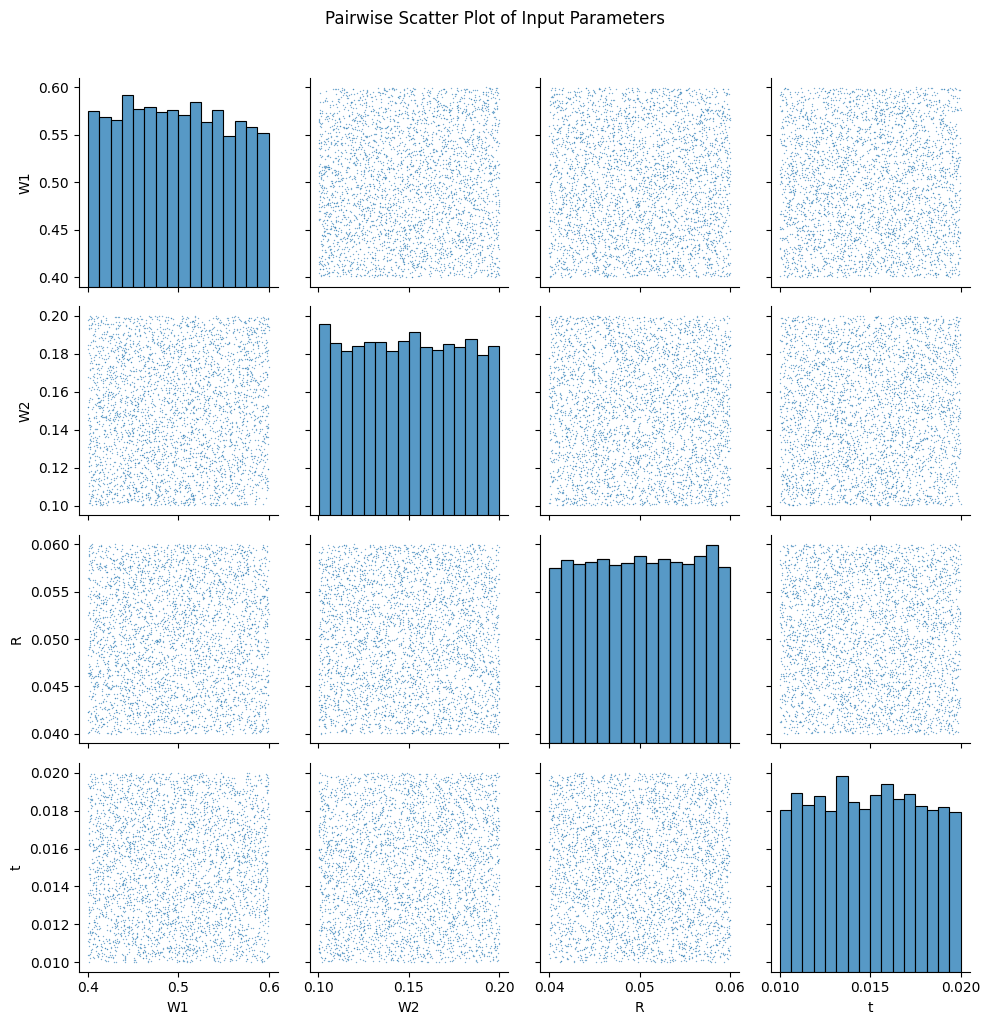

In [121]:
# --- Improved Pairwise Scatter Plot ---
sns.pairplot(
    df[['W1', 'W2', 'R', 't']],
    plot_kws={'s': 1, 'alpha': 0.6}  # smaller point size and some transparency
)
plt.suptitle("Pairwise Scatter Plot of Input Parameters", y=1.02)
plt.tight_layout()
plt.show()

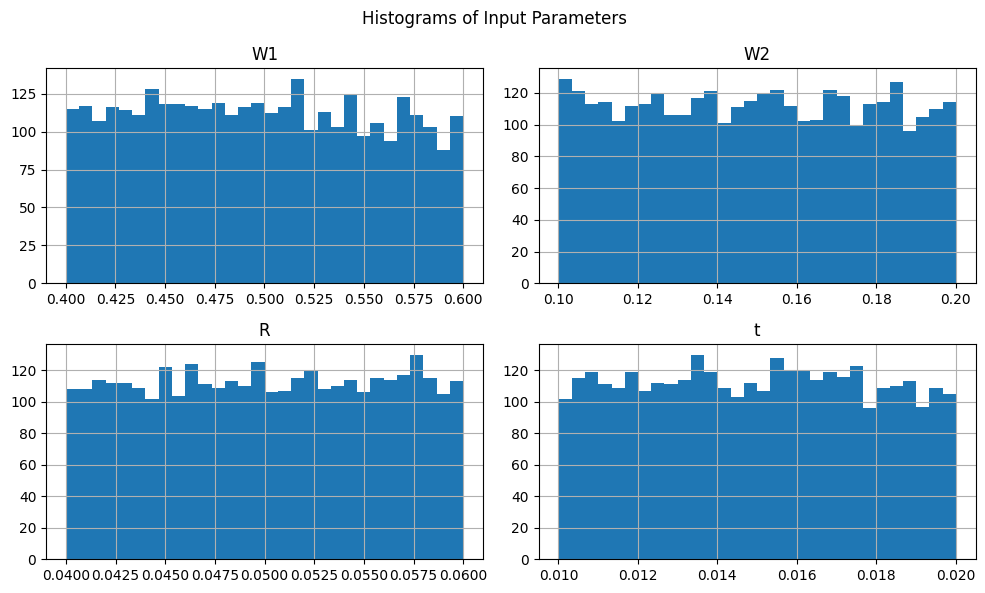

In [127]:
## Histograms
df[['W1', 'W2', 'R', 't']].hist(bins=30, figsize=(10, 6))
plt.suptitle("Histograms of Input Parameters")
plt.tight_layout()
plt.show()

# Gaussian Process Regression Model

Data preparation:

In [157]:
#Shuffle the combined dataset first to get a representative sample
df_combined = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Select only the first 400 rows for kernel testing
df_gpr_comparison = df_combined.iloc[:400]

# Split the dataset into the input features and output stress
X = df_gpr_comparison[['W1', 'W2', 'R', 't']].values
Y = df_gpr_comparison['sigma_max'].values


# Normalising inputs to [0, 1] (helps GPR performance)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Cross-Validation:

RBF:
  Mean R²:  0.9983 ± 0.0006
  Mean MAE: 0.3351 ± 0.0532



/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


RBF + WhiteKernel:
  Mean R²:  0.9999 ± 0.0000
  Mean MAE: 0.0791 ± 0.0133



/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.ht

Matern 32:
  Mean R²:  0.9997 ± 0.0003
  Mean MAE: 0.1261 ± 0.0313



/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

Matern 52:
  Mean R²:  0.9999 ± 0.0001
  Mean MAE: 0.1049 ± 0.0178



/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


RBF (alpha=1e-4):
  Mean R²:  0.9999 ± 0.0001
  Mean MAE: 0.0836 ± 0.0173

Summary of Best Kernels:
  Highest Mean R²:  RBF + WhiteKernel → 0.9999
  Lowest Mean MAE: RBF + WhiteKernel → 0.0791


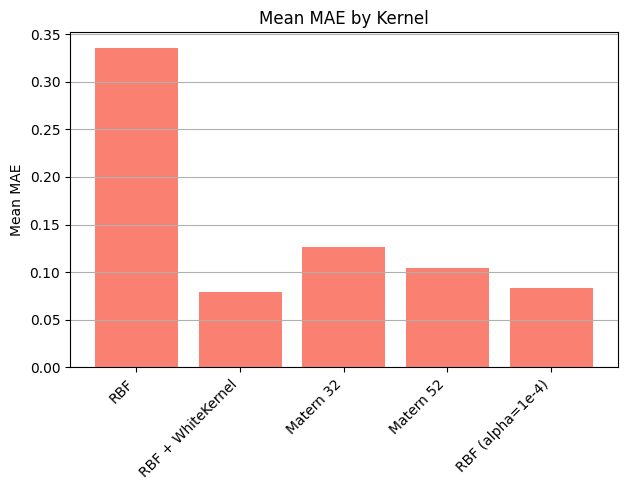

Results: 

-----------------------
kernel: RBF, R_2 = 0.9983349867082142, MAE = 0.3350674967830901
-----------------------
kernel: RBF + WhiteKernel, R_2 = 0.9999257843528373, MAE = 0.07914280506824936
-----------------------
kernel: Matern 32, R_2 = 0.9996834627706368, MAE = 0.12613492781882257
-----------------------
kernel: Matern 52, R_2 = 0.9998620705413017, MAE = 0.10489872445799649
-----------------------
kernel: RBF (alpha=1e-4), R_2 = 0.9999075407778903, MAE = 0.08364932090351004


In [166]:
from sklearn.model_selection import cross_validate, KFold

# Define kernels
kernels = {
    "RBF": C(1.0, (1e-4, 1e4)) * RBF(length_scale=1.0, length_scale_bounds=(1e-4, 1e4)),
    "RBF + WhiteKernel": (C(1.0, (1e-4, 1e4)) * RBF(1.0, (1e-4, 1e4))) + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-6, 1e1)),
    "Matern 32": C(1.0, (1e-4, 1e4)) * Matern(length_scale=1.0, nu=1.5),
    "Matern 52": C(1.0, (1e-4, 1e4)) * Matern(length_scale=1.0, nu=2.5),
    "RBF (alpha=1e-4)": C(1.0, (1e-4, 1e4)) * RBF(length_scale=1.0, length_scale_bounds=(1e-4, 1e4))
}

# Cross-validation settings
cv = KFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for name, kernel in kernels.items():
    if name == "RBF (alpha=1e-4)":
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-4, n_restarts_optimizer=15, normalize_y=True)
    else:
        gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15, normalize_y=True)

    # Perform cross-validation
    scores = cross_validate(
        gpr,
        X_scaled,
        Y,
        cv=cv,
        scoring=("r2", "neg_mean_absolute_error"),
        return_train_score=False
    )

    # Convert neg_mean_absolute_error to positive MAE
    mae_scores = -scores["test_neg_mean_absolute_error"]
    r2_scores = scores["test_r2"]

    results[name] = {
        "mean_r2": np.mean(r2_scores),
        "std_r2": np.std(r2_scores),
        "mean_mae": np.mean(mae_scores),
        "std_mae": np.std(mae_scores)
    }

    print(f"{name}:")
    print(f"  Mean R²:  {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
    print(f"  Mean MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
    print()

# Identify best performing kernels
best_r2_kernel = max(results.items(), key=lambda x: x[1]['mean_r2'])
best_mae_kernel = min(results.items(), key=lambda x: x[1]['mean_mae'])

print("Summary of Best Kernels:")
print(f"  Highest Mean R²:  {best_r2_kernel[0]}, {best_r2_kernel[1]['mean_r2']:.4f}")
print(f"  Lowest Mean MAE: {best_mae_kernel[0]}, {best_mae_kernel[1]['mean_mae']:.4f}")

# Prepare data for plotting
kernel_names = list(results.keys())
mean_r2s = [results[k]['mean_r2'] for k in kernel_names]
mean_maes = [results[k]['mean_mae'] for k in kernel_names]

x = range(len(kernel_names))

plt.figure(figsize=(12, 5))

# MAE plot
plt.subplot(1, 2, 2)
plt.bar(x, mean_maes, color='salmon')
plt.xticks(x, kernel_names, rotation=45, ha='right')
plt.ylabel("Mean MAE")
plt.title("Mean MAE by Kernel")
plt.grid(axis='y')

plt.tight_layout()
plt.savefig("figures/kernel_crossval_summary.png", dpi=300)
plt.show()

# Print out the results
print("Results: \n")
for _ in range(len(kernel_names)):
    print("-----------------------")
    print(f"kernel: {kernel_names[_]}, R_2 = {mean_r2s[_]}, MAE = {mean_maes[_]}")

## GPR training with different kernels:

In [147]:
# Define candidate kernels
kernels = {
    "RBF": C(1.0, (1e-4, 1e4)) * RBF(length_scale=1.0, length_scale_bounds=(1e-4, 1e4)),
    "RBF+ WhiteKernel": (C(1.0, (1e-4, 1e4)) * RBF(1.0, (1e-4, 1e4))) + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-5, 1e5)),
    "Matern 32": C(1.0, (1e-4, 1e4)) * Matern(length_scale=1.0, nu=1.5),
    "Matern 52": C(1.0, (1e-4, 1e4)) * Matern(length_scale=1.0, nu=2.5)
}

best_model = None
best_kernel_name = None
best_score = -np.inf
results = {}

# Compare all kernels
for name, kernel in kernels.items():
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15, normalize_y=True)
    gpr.fit(X_train, Y_train)

    Y_val_pred = gpr.predict(X_val)
    val_score = r2_score(Y_val, Y_val_pred)
    val_mae = mean_absolute_error(Y_val, Y_val_pred)

    Y_test_pred = gpr.predict(X_test)
    test_score = r2_score(Y_test, Y_test_pred)
    test_mae = mean_absolute_error(Y_test, Y_test_pred)

    print(f"{name}:\n"
          f"  Validation R² = {val_score:.4f}, MAE = {val_mae:.4f}\n"
          f"  Test R²       = {test_score:.4f}, MAE = {test_mae:.4f}\n")

    if val_score > best_score:
        best_score = val_score
        best_model = gpr
        best_kernel_name = name

    # Store results for plotting
    results[name] = {
        'val_true': Y_val,
        'val_pred': Y_val_pred,
        'test_true': Y_test,
        'test_pred': Y_test_pred,
        'val_r2': val_score,
        'val_mae': val_mae,
        'test_r2': test_score,
        'test_mae': test_mae
    }

print(f"Best kernel: {best_kernel_name} (Validation R² = {best_score:.4f})")

# --- Plots ---

# 1. Residuals Histogram
for name, data in results.items():
    residuals = data['test_pred'] - data['test_true']
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True)
    plt.title(f"{name} - Residuals (Prediction Error on Test)")
    plt.xlabel("Prediction Error")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(f"figures/{name}_residuals.png", dpi=300)
    plt.close()

# 2. Bar Chart: R² and MAE
kernel_names = list(results.keys())
val_r2s = [results[k]['val_r2'] for k in kernel_names]
test_r2s = [results[k]['test_r2'] for k in kernel_names]
val_maes = [results[k]['val_mae'] for k in kernel_names]
test_maes = [results[k]['test_mae'] for k in kernel_names]

x = range(len(kernel_names))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(x, val_r2s, width=0.4, label='Validation R²')
plt.bar([i + 0.4 for i in x], test_r2s, width=0.4, label='Test R²')
plt.xticks([i + 0.2 for i in x], kernel_names, rotation=45)
plt.ylabel("R² Score")
plt.title("R² Scores by Kernel")
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(x, val_maes, width=0.4, label='Validation MAE')
plt.bar([i + 0.4 for i in x], test_maes, width=0.4, label='Test MAE')
plt.xticks([i + 0.2 for i in x], kernel_names, rotation=45)
plt.ylabel("MAE")
plt.title("MAE by Kernel")
plt.legend()

plt.tight_layout()
plt.savefig("figures/kernel_comparison_barplots.png", dpi=300)
plt.close()

RBF:
  Validation R² = 0.9987, MAE = 0.2957
  Test R²       = 0.9991, MAE = 0.2877

RBF+ WhiteKernel:
  Validation R² = 0.9999, MAE = 0.0741
  Test R²       = 1.0000, MAE = 0.0674



/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Matern 32:
  Validation R² = 0.9996, MAE = 0.1247
  Test R²       = 0.9998, MAE = 0.1139



/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Matern 52:
  Validation R² = 0.9998, MAE = 0.1019
  Test R²       = 0.9999, MAE = 0.0983

Best kernel: RBF+ WhiteKernel (Validation R² = 0.9999)


## RBF + White Noise - determining the sample size

In [6]:
def evaluate_sample_efficiency(df, sample_sizes, repeats=5):
    """
    Evaluates GPR performance for various training sample sizes and saves figures.

    Parameters:
    - df: full DataFrame containing 'W1', 'W2', 'R', 't', 'sigma_max', and 'time'
    - sample_sizes: list of training sizes to test
    - repeats: how many random splits per sample size

    Returns:
    - Dictionary with MAEs, MAPEs, and simulation times per sample size
    """
    assert 'runtime' in df.columns, "The dataset must include a 'time' column."

    X_full = df[['W1', 'W2', 'R', 't']].values
    Y_full = df['sigma_max'].values
    time_full = df['runtime'].values

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_full)

    kernel = (C(1.0, (1e-3, 1e5)) * RBF(1.0, (1e-4, 1e5))) + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-6, 1e1))

    mae_results = []
    mape_results = []
    time_results = []

    for n in sample_sizes:
        maes, mapes = [], []
        total_time = 0.0

        splitter = ShuffleSplit(n_splits=repeats, train_size=n, random_state=42)
        print(f"Evaluating sample size: {n}")

        for train_idx, test_idx in splitter.split(X_scaled):
            X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
            Y_train, Y_test = Y_full[train_idx], Y_full[test_idx]

            # Track total simulation time of the current training set
            total_time += np.sum(time_full[train_idx])

            gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
            gpr.fit(X_train, Y_train)
            Y_pred = gpr.predict(X_test)

            mae = mean_absolute_error(Y_test, Y_pred)
            mape = mean_absolute_percentage_error(Y_test, Y_pred)

            maes.append(mae)
            mapes.append(mape)

        mae_results.append(np.mean(maes))
        mape_results.append(np.mean(mapes) * 100)  # as percent
        time_results.append(total_time / repeats /3600)  # average total time over folds

        print(f"  Mean MAE = {np.mean(maes):.4f}, Mean MAPE = {np.mean(mapes)*100:.2f}%, Avg. Sim Time = {total_time/repeats:.2f} s")

    # --- Plot 1: MAE and MAPE vs Sample Size ---
    fig, ax1 = plt.subplots(figsize=(10, 5))

    color_mae = 'tab:blue'
    color_mape = 'tab:orange'

    ax1.set_xlabel("Training sample size")
    ax1.set_ylabel("Mean MAE", color=color_mae)
    ax1.plot(sample_sizes, mae_results, marker='o', color=color_mae, label='Mean MAE')
    ax1.tick_params(axis='y', labelcolor=color_mae)

    ax2 = ax1.twinx()
    ax2.set_ylabel("Mean MAPE (%)", color=color_mape)
    ax2.plot(sample_sizes, mape_results, marker='s', color=color_mape, label='Mean MAPE (%)')
    ax2.tick_params(axis='y', labelcolor=color_mape)

    plt.title("GPR Performance vs Training Sample Size")
    fig.tight_layout()
    plt.grid(True)
    fig.savefig("figures/gpr_performance_vs_sample_size.png", dpi=300)
    plt.show()

    # --- Plot 2: Total Simulation Time vs Sample Size ---
    plt.figure(figsize=(8, 5))
    plt.bar(sample_sizes, time_results, color='tab:green')
    plt.xlabel("Training sample size")
    plt.ylabel("Average Total Simulation Time (h)")
    plt.title("Total Simulation Time vs Training Sample Size")
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig("figures/simulation_time_vs_sample_size.png", dpi=300)
    plt.show()

    return {
        "sample_sizes": sample_sizes,
        "mae": mae_results,
        "mape": mape_results,
        "avg_sim_time": time_results
    }

In [ ]:
sample_sizes = [50, 100, 200, 400, 500, 600, 700, 800, 1000]
results = evaluate_sample_efficiency(df, sample_sizes, repeats=20)

In [11]:
print("\n GPR Model Evaluation Summary")
print("────────────────────────────────────────────")
print(f"{'Samples':>10} | {'MAE':>10} | {'MAPE (%)':>10} | {'Time (h)':>10}")
print("────────────────────────────────────────────")
for n, mae, mape, time in zip(results['sample_sizes'],
                              results['mae'],
                              results['mape'],
                              results['avg_sim_time']):
    print(f"{n:>10} | {mae:>10.4f} | {mape:>10.2f} | {time:>10.2f}")
print("────────────────────────────────────────────")


 GPR Model Evaluation Summary
────────────────────────────────────────────
   Samples |        MAE |   MAPE (%) |   Time (h)
────────────────────────────────────────────
        50 |     0.3429 |       0.63 |       0.33
       100 |     0.1688 |       0.30 |       0.66
       200 |     0.0945 |       0.17 |       1.34
       400 |     0.0743 |       0.14 |       2.68
       500 |     0.0695 |       0.13 |       3.36
       600 |     0.0665 |       0.12 |       4.02
       700 |     0.0644 |       0.12 |       4.70
       800 |     0.0630 |       0.12 |       5.37
      1000 |     0.0610 |       0.11 |       6.71
────────────────────────────────────────────


## Final GPR Model Training:

In [12]:
# --- PARAMETERS ---
n_final_samples = 400
model_dir = "models"
data_dir = "data"
os.makedirs(model_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)

# --- Sample and preprocess ---
df_final = df.sample(n=n_final_samples, random_state=42).reset_index(drop=True)
X = df_final[['W1', 'W2', 'R', 't']].values
Y = df_final['sigma_max'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# --- Define and train GPR ---
kernel = (C(1.0, (1e-3, 1e5)) * RBF(1.0, (1e-4, 1e5))) + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-6, 1e1))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
gpr.fit(X_scaled, Y)

# --- Save model, scaler, and training dataset ---
joblib.dump(gpr, f"{model_dir}/final_gpr_model.pkl")
joblib.dump(scaler, f"{model_dir}/final_scaler.pkl")
df_final.to_csv(f"{data_dir}/final_gpr_training_data.csv", index=False)

print(f"Final GPR model and scaler saved to '{model_dir}/'")
print(f"Training dataset saved to '{data_dir}/final_gpr_training_data.csv'")

Final GPR model and scaler saved to 'models/'
Training dataset saved to 'data/final_gpr_training_data.csv'


# Final GPR Model Evaluation

In [14]:
# --- Load trained model, scaler, and training data ---
import joblib
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Paths
model_path = f"models/final_gpr_model.pkl"
scaler_path = f"models/final_scaler.pkl"
train_data_path = f"data/final_gpr_training_data.csv"

# Load components
gpr = joblib.load(model_path)
scaler = joblib.load(scaler_path)
df_train = pd.read_csv(train_data_path)

# Create evaluation set: all data not used in training
df_eval = df.drop(df_train.index, axis=0).reset_index(drop=True)

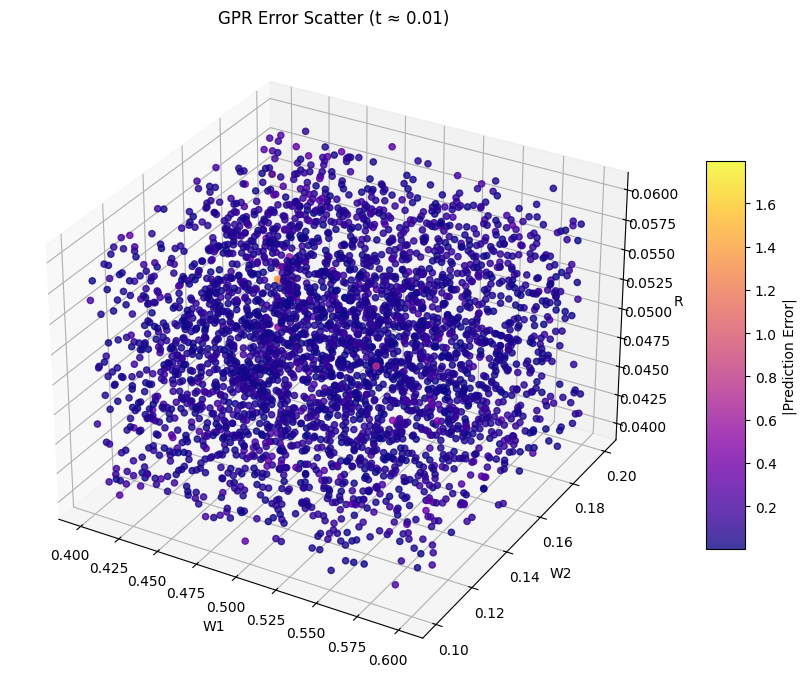

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# --- Optionally fix t to a constant (e.g. median) ---
fixed_t = df['t'].median()
df_filtered = df[df['t'].between(fixed_t - 0.01, fixed_t + 0.01)].copy()  # small window around fixed t

# --- Extract features and true σ_max ---
X = df_filtered[['W1', 'W2', 'R', 't']].values
Y_true = df_filtered['sigma_max'].values

# --- Scale and predict ---
X_scaled = scaler.transform(X)
Y_pred = gpr.predict(X_scaled)

# --- Compute absolute error ---
abs_error = np.abs(Y_pred - Y_true)

# --- Plot: W1, W2, R with color = |prediction error| ---
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(df_filtered['W1'], df_filtered['W2'], df_filtered['R'],
                c=abs_error, cmap='plasma', s=20, alpha=0.8)

ax.set_xlabel("W1")
ax.set_ylabel("W2")
ax.set_zlabel("R")
ax.set_title(f"GPR Error Scatter (t ≈ {fixed_t:.2f})")

cb = fig.colorbar(sc, ax=ax, shrink=0.6, aspect=10, label="|Prediction Error|")

plt.tight_layout()
plt.show()


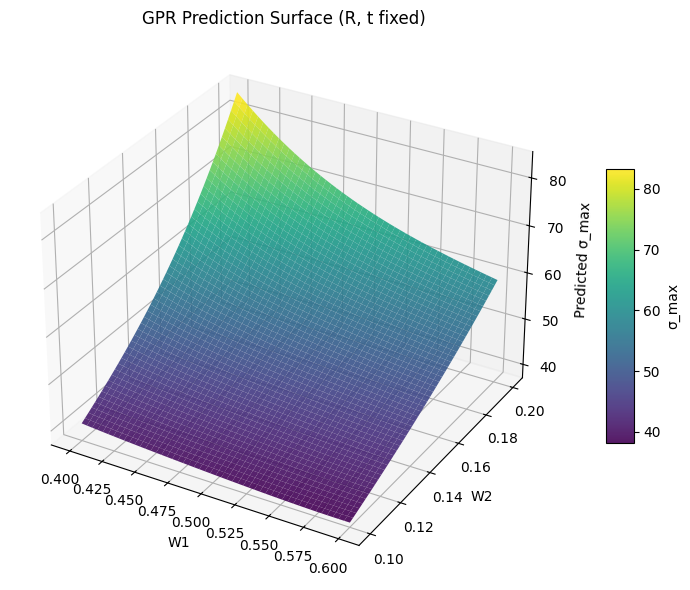

In [22]:
# --- Fix R and t to median values (or any constant) ---
fixed_R = df['R'].median()
fixed_t = df['t'].median()

# --- Create grid over W1 and W2 ---
w1_range = np.linspace(df['W1'].min(), df['W1'].max(), 50)
w2_range = np.linspace(df['W2'].min(), df['W2'].max(), 50)
W1_grid, W2_grid = np.meshgrid(w1_range, w2_range)

# --- Prepare inputs to model (W1, W2 vary; R, t fixed) ---
grid_points = np.c_[W1_grid.ravel(), W2_grid.ravel(),
                    np.full(W1_grid.size, fixed_R),
                    np.full(W1_grid.size, fixed_t)]

# --- Scale and predict ---
grid_points_scaled = scaler.transform(grid_points)
Z_pred = gpr.predict(grid_points_scaled)
Z_grid = Z_pred.reshape(W1_grid.shape)

# --- Plot the surface ---
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(W1_grid, W2_grid, Z_grid,
                       cmap='viridis', edgecolor='none', alpha=0.9)

ax.set_xlabel("W1")
ax.set_ylabel("W2")
ax.set_zlabel("Predicted σ_max")
ax.set_title("GPR Prediction Surface (R, t fixed)")
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label="σ_max")

plt.tight_layout()
plt.show()


In [32]:
# Extract inputs and targets from evaluation set
X_eval = df_eval[['W1', 'W2', 'R', 't']].values
Y_eval = df_eval['sigma_max'].values
X_eval_scaled = scaler.transform(X_eval)

# Predict
Y_pred = gpr.predict(X_eval_scaled)

# Evaluate
mae = mean_absolute_error(Y_eval, Y_pred)
mape = mean_absolute_percentage_error(Y_eval, Y_pred) * 100

print(f"GPR Evaluation on Unseen Data:")
print(f"MAE:  {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

GPR Evaluation on Unseen Data:
MAE:  0.0724
MAPE: 0.14%


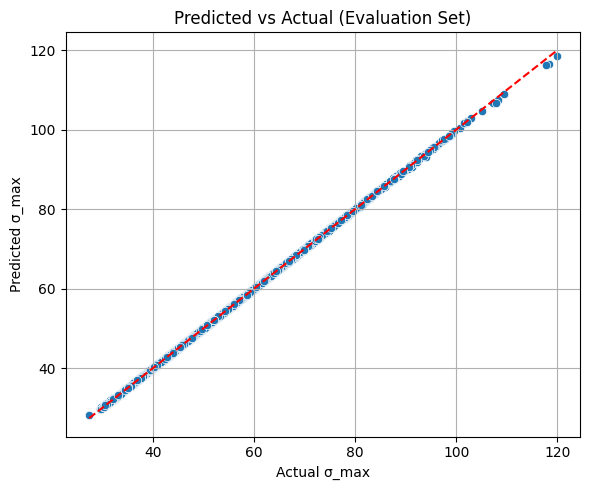

In [33]:
plt.figure(figsize=(6, 5))
sns.scatterplot(x=Y_eval, y=Y_pred)
plt.plot([Y_eval.min(), Y_eval.max()], [Y_eval.min(), Y_eval.max()], 'r--')
plt.xlabel("Actual σ_max")
plt.ylabel("Predicted σ_max")
plt.title("Predicted vs Actual (Evaluation Set)")
plt.grid(True)
plt.tight_layout()
plt.show()

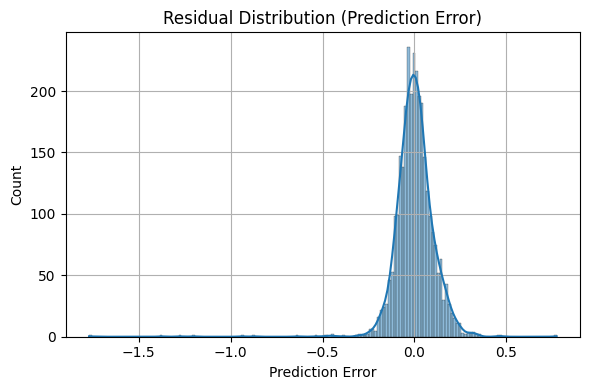

In [34]:
residuals = Y_pred - Y_eval
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution (Prediction Error)")
plt.xlabel("Prediction Error")
plt.grid(True)
plt.tight_layout()
plt.show()

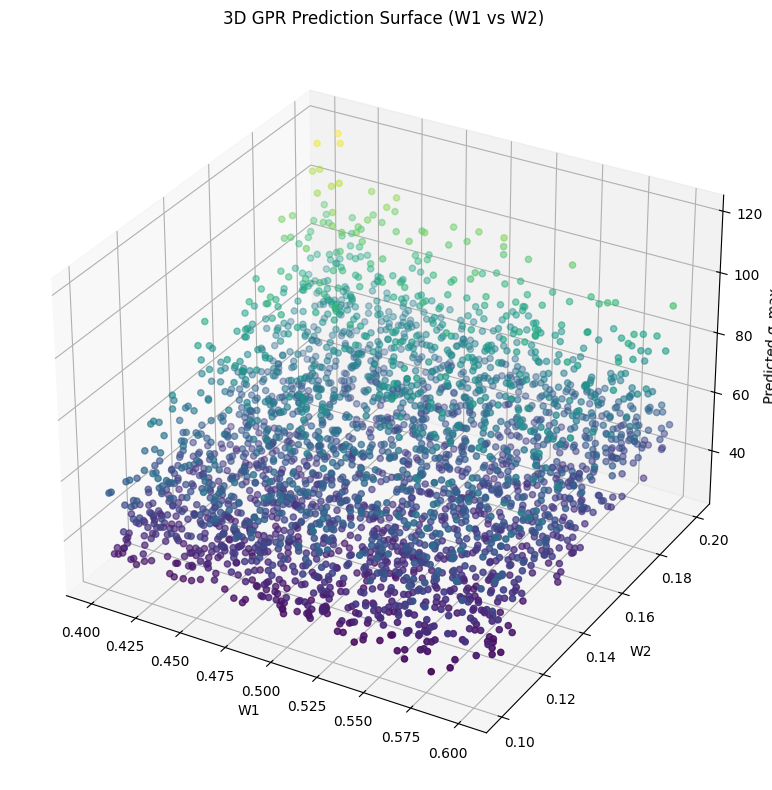

In [35]:
# Choose two input variables for axes
X_plot = df_eval[['W1', 'W2']].values
Y_surface = Y_pred

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_plot[:, 0], X_plot[:, 1], Y_surface, c=Y_surface, cmap='viridis', s=20)
ax.set_xlabel("W1")
ax.set_ylabel("W2")
ax.set_zlabel("Predicted σ_max")
ax.set_title("3D GPR Prediction Surface (W1 vs W2)")
plt.tight_layout()
plt.show()

# Neural Network

## Key Hyperparameters in This Code

| Hyperparameter         | Line(s)               | Notes |
|------------------------|-----------------------|-------|
| Architecture (layers, neurons) | `Dense(32)`, `Dense(16)`, `Dense(1)` | Core design of NN |
| Activation functions   | `activation='relu'`   | Could try `tanh`, `elu`, etc. |
| Optimizer              | `'adam'`              | Could try SGD, RMSprop, etc. |
| Loss function          | `'mse'`               | Could try `'mae'`, `'huber'` |
| Epochs                 | `epochs=200`          | Max training time |
| Batch size             | `batch_size=32`       | Affects convergence speed |
| Early stopping patience| `patience=10`         | When to stop if no val improvement |
| Validation split ratio | `train_test_split(...)` | Controls size of val set |

In [5]:
# Load your dataset
df_NN = df
#df_NN = df.sample(n=100, random_state=42).reset_index(drop=True)

Base Setup:

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Inputs and outputs
X = df[['W1', 'W2', 'R', 't']].values
y = df['sigma_max'].values.reshape(-1, 1)

# Train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize input and output
input_scaler = StandardScaler()
output_scaler = StandardScaler()

X_train_scaled = input_scaler.fit_transform(X_train)
X_val_scaled = input_scaler.transform(X_val)
X_test_scaled = input_scaler.transform(X_test)

y_train_scaled = output_scaler.fit_transform(y_train)
y_val_scaled = output_scaler.transform(y_val)
y_test_scaled = output_scaler.transform(y_test)

# Build the neural network
model = Sequential([
    Dense(32, activation='relu', input_shape=(4,)),  # hidden layer 1
    Dense(16, activation='relu'),                    # hidden layer 2
    Dense(1)                                         # output layer
])

model.compile(optimizer='adam', loss='mse')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=500,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Predict on test set
y_pred_scaled = model.predict(X_test_scaled)
y_pred = output_scaler.inverse_transform(y_pred_scaled)

# Evaluate MAPE
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
print(f"Test MAPE: {mape:.2f}%")

# Evaluate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Test MAE: {mae:.4f}")

# Manual Hyperparameter Grid Search

In [4]:
activations = ['relu', 'tanh', 'sigmoid']
optimisers = ['adam', 'rmsprop', 'sgd']
hidden_sizes = [(32,), (64,), (64, 32)]

In [3]:
# --- Load and preprocess your data ---
X = df[['W1', 'W2', 'R', 't']].values
y = df['sigma_max'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Loop over activation × optimizer × hidden layer size
for act in activations:
    for opt in optimisers:
        for size in hidden_sizes:

            # Build model
            model = keras.Sequential()
            model.add(layers.Input(shape=(X.shape[1],)))
            for units in size:
                model.add(layers.Dense(units, activation=act))
            model.add(layers.Dense(1))

            model.compile(optimizer=opt, loss='mse', metrics=['mae'])

            # Add early stopping
            early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

            # Train
            try:
                history = model.fit(
                    X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=200,
                    batch_size=32,
                    callbacks=[early_stop],
                    verbose=1
                )

                # Predict and check for NaNs
                y_pred = model.predict(X_val).flatten()

                if np.isnan(y_pred).any() or np.isnan(y_val).any():
                    print(f"NaNs detected — Skipping: {act}, {opt}, {size}")
                    continue

                mae = mean_absolute_error(y_val, y_pred)
                rmse = np.sqrt(mean_squared_error(y_val, y_pred))

                results.append({
                    "activation": act,
                    "optimizer": opt,
                    "layers": size,
                    "val_mae": mae,
                    "val_rmse": rmse
                })

                print(f"{act}, {opt}, {size} → MAE: {mae:.4f}, RMSE: {rmse:.4f}")

            except Exception as e:
                print(f"Error with config {act}, {opt}, {size}: {e}")

NameError: name 'activations' is not defined

In [12]:
# Now to sift through results:
df_results = pd.DataFrame(results)
df_results_sorted = df_results.sort_values(by='val_mae')
print(df_results_sorted.head(30))

   activation optimizer    layers    val_mae   val_rmse
31    sigmoid       sgd  (64, 32)   0.119315   0.230405
21       tanh       sgd     (64,)   0.122129   0.220531
20       tanh       sgd     (32,)   0.150135   0.283325
29    sigmoid       sgd     (32,)   0.161003   0.292115
18       tanh   rmsprop     (64,)   0.181790   0.334649
22       tanh       sgd  (64, 32)   0.201584   0.328017
30    sigmoid       sgd     (64,)   0.201975   0.330056
17       tanh   rmsprop     (32,)   0.218914   0.450639
15       tanh      adam     (64,)   0.265741   0.492003
27    sigmoid   rmsprop     (64,)   0.316710   0.557178
26    sigmoid   rmsprop     (32,)   0.348233   0.665199
14       tanh      adam     (32,)   0.358179   0.703046
24    sigmoid      adam     (64,)   0.486877   0.822255
23    sigmoid      adam     (32,)   0.810470   1.278782
12       relu       sgd     (32,)   2.272790   3.190379
1        relu      adam     (64,)   2.276373   3.180794
10       relu   rmsprop     (64,)   2.293977   3

# Keras Tuner Hyperparameter Search

In [16]:
# --- Data ---
X = df[['W1', 'W2', 'R', 't']].values
y = df['sigma_max'].values

# Scale inputs and outputs
input_scaler = StandardScaler()
output_scaler = StandardScaler()
X_scaled = input_scaler.fit_transform(X)
y_scaled = output_scaler.fit_transform(y.reshape(-1, 1))

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# --- Define model builder function ---
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X.shape[1],)))

    # Tune number of layers and units
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                units=hp.Int(f"units_{i}", min_value=16, max_value=128, step=16),
                activation=hp.Choice("activation", ["relu", "tanh", "sigmoid"])
            )
        )
    
    model.add(layers.Dense(1))  # Output layer

    model.compile(
        optimizer=hp.Choice("optimizer", ["adam", "sgd", "rmsprop"]),
        loss="mse",
        metrics=["mae"]
    )
    
    return model

# --- Initialize tuner ---
tuner = kt.RandomSearch(
    build_model,
    objective="val_mae",
    max_trials=20,
    executions_per_trial=1,
    overwrite=True,
    directory="keras_tuner",
    project_name="regression_model"
)

# --- Early stopping ---
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# --- Search ---
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- Retrieve best model ---
best_model = tuner.get_best_models(1)[0]

# --- Evaluate ---
y_pred_scaled = best_model.predict(X_val)
y_pred = output_scaler.inverse_transform(y_pred_scaled)
y_val_true = output_scaler.inverse_transform(y_val)

mae = mean_absolute_error(y_val_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_val_true, y_pred))
print(f"Best model performance → MAE: {mae:.4f}, RMSE: {rmse:.4f}")


Trial 20 Complete [00h 00m 33s]
val_mae: 0.01845935545861721

Best val_mae So Far: 0.00673348642885685
Total elapsed time: 00h 13m 59s
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Best model performance → MAE: 0.0971, RMSE: 0.1727


/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [17]:
best_trial = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
for param in best_trial.values:
    print(f"{param}: {best_trial.get(param)}")

Best hyperparameters:
num_layers: 2
units_0: 96
activation: sigmoid
optimizer: adam
units_1: 16


# Well Tuned Neural Network

In [123]:
# --- Reproducibility ---
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

X = df[['W1', 'W2', 'R', 't']].values
y = df['sigma_max'].values.reshape(-1, 1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

# --- Scale inputs and outputs ---
input_scaler = StandardScaler()
output_scaler = StandardScaler()

X_train_scaled = input_scaler.fit_transform(X_train)
X_val_scaled = input_scaler.transform(X_val)
X_test_scaled = input_scaler.transform(X_test)

y_train_scaled = output_scaler.fit_transform(y_train)
y_val_scaled = output_scaler.transform(y_val)
y_test_scaled = output_scaler.transform(y_test)

# --- Build model using best hyperparameters ---
model = keras.Sequential([
    layers.Dense(96, activation='sigmoid', input_shape=(4,)),  # Layer 1
    layers.Dense(16, activation='sigmoid'),                    # Layer 2
    layers.Dense(1)                                            # Output layer
])

model.compile(
    optimizer='adam',     # Best found optimizer
    loss='mse',
    metrics=['mae']
)

# --- Callbacks ---
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

lr_schedule = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-5
)

# --- Train ---
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=500,
    batch_size=32,
    callbacks=[early_stop, lr_schedule],
    verbose=1
)

# --- Evaluate ---
y_pred_scaled = model.predict(X_test_scaled)
y_pred = output_scaler.inverse_transform(y_pred_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # in %

print(f"\nFinal Test MAE: {mae:.4f}")
print(f"Final Test RMSE: {rmse:.4f}")
print(f"Final Test MAPE: {mape:.2f}%")
# --- Save model + scalers ---
os.makedirs("models", exist_ok=True)
model.save("models/final_nn_model.keras")
joblib.dump(input_scaler, "models/final_input_scaler.pkl")
joblib.dump(output_scaler, "models/final_output_scaler.pkl")

print("\nModel and scalers saved to 'models/' folder.")


Epoch 1/500


/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9269 - mae: 0.7447 - val_loss: 0.7617 - val_mae: 0.6869 - learning_rate: 0.0010
Epoch 2/500
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6111 - mae: 0.6104 - val_loss: 0.3305 - val_mae: 0.4320 - learning_rate: 0.0010
Epoch 3/500
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2173 - mae: 0.3329 - val_loss: 0.0965 - val_mae: 0.1795 - learning_rate: 0.0010
Epoch 4/500
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0703 - mae: 0.1609 - val_loss: 0.0698 - val_mae: 0.1541 - learning_rate: 0.0010
Epoch 5/500
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0550 - mae: 0.1493 - val_loss: 0.0598 - val_mae: 0.1407 - learning_rate: 0.0010
Epoch 6/500
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0463 - mae: 0.1347 - val_loss: 0.0515 - val_mae: 0.1281 - learning_rate: 0.0010
Epoch 7/500
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0393 - mae: 0.1233 - val_loss: 0.0452 - val_mae: 0.1204 - learning_rate: 0.0010
Epoch 8/500
74/74 ━━━━━━━